<a href="https://colab.research.google.com/github/arivannu/Neural-Networks/blob/main/Classification_of_MR_Images_for_Brain_Tumors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of MR Images - Brain Tumors


Unzipping the file that contains the MR images

In [1]:
from zipfile import ZipFile

In [2]:
with ZipFile('drive/MyDrive/archive.zip', 'r') as ZipObj:
 ZipObj.extractall('drive/MyDrive/MRI_Images')   # extracting folders from zip file

#Importing dataset

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import os  # to operate with directories of the images
import cv2  # to operate with images

In [4]:
train_dir = "/content/drive/MyDrive/MRI_Images/Training"  # directory for the training set
test_dir = "/content/drive/MyDrive/MRI_Images/Testing"   # directory for the test set

# Creating the training set with associated labels and the test set

Training set

In [5]:
training_set = []
img_size = 128
categories = ["glioma", "meningioma", "notumor", "pituitary"]

def create_train_set():

  for category in categories:
    path = os.path.join(train_dir, category)   # now doing a loop over the categories of the training set 
                                               # in the training folder

    num_class = categories.index(category)

    for image in os.listdir(path):      # now doing a loop over all the images that are present in that path, 
                                        # loading them in a grayscale 8 bit format

      try:  # some images can be damaged, so the code is gonna try to do the following things

        img_array = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE)    

        new_img_array = cv2.resize(img_array, (img_size, img_size))   # resizing every image to be 128x128 pxs

        training_set.append([new_img_array, num_class])      # the training set vector collects 
                                                             # all the processed images 
                                                             # and their classification

      except:

        pass

  return(training_set)


training_set = create_train_set()

Test set

In [6]:
test_set = []

def create_test_set():

  for category in categories:
    path = os.path.join(test_dir, category)  

    num_class = categories.index(category)

    for image in os.listdir(path):      

      try: 

        img_array = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE)    

        new_img_array = cv2.resize(img_array, (img_size, img_size))  

        test_set.append([new_img_array, num_class])     


      except:

        pass

  return(test_set)


test_set = create_test_set()

In [7]:
# shuffling training set and test set
import random

random.shuffle(training_set)
random.shuffle(test_set)

In [8]:
# dividing the training set and the test set into training/test features and training/test labels

x_train = []
y_train = []

x_test = []
y_test = []

for features, labels in training_set:
  x_train.append(features)
  y_train.append(labels)

for features, labels in test_set:
  x_test.append(features)
  y_test.append(labels)

print(len(x_train))
print(len(y_train))

print(len(x_test))
print(len(y_test))

5698
5698
1296
1296


In [9]:
perc = (len(x_test))/(len(x_train) + len(x_test))   # percentage of test set wrt the total number of images
print("%.2f" %perc)

0.19


# Data Preparation

In [ ]:
# transforming the x_train and the x_test so that it can be manipulated by keras

x_train = np.array(x_train)
x_train.reshape(-1, img_size, img_size, 1)    # 128x128 pxs
                                              # 1 indicates the grayscale

x_test = np.array(x_test)
x_test.reshape(-1, img_size, img_size, 1)

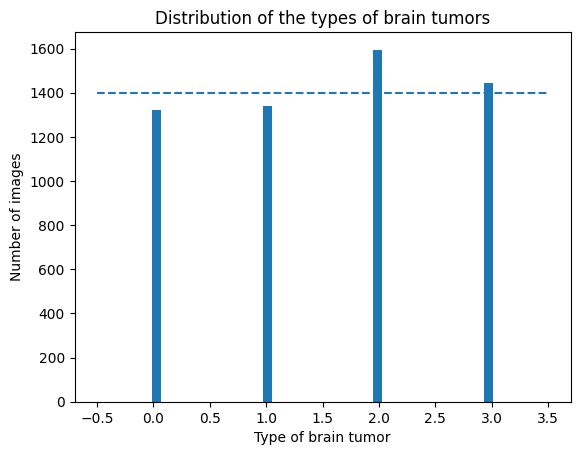

In [11]:
# showing that the percentage of each class is similar

histogram = plt.figure(1)
plt.hlines(1400, -0.5, 3.5, linestyles='--')
plt.hist(y_train, bins=np.linspace(-0.5,3.5))
plt.title('Distribution of the types of brain tumors')
plt.xlabel('Type of brain tumor')
plt.ylabel('Number of images');

In [12]:
from sklearn.model_selection import train_test_split

val_size = 0.1

X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=val_size, stratify=y_train)

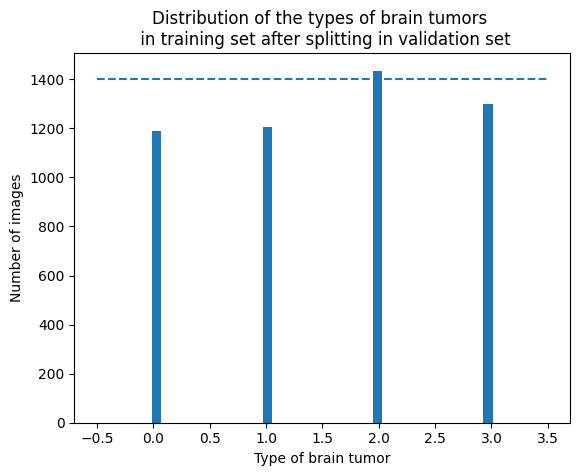

In [13]:
# showing that the percentage of each class is similar even after the splitting because of the "stratify" term

histogram = plt.figure(2)
plt.hlines(1400, -0.5, 3.5, linestyles='--')
plt.hist(Y_train, bins=np.linspace(-0.5,3.5))
plt.title('Distribution of the types of brain tumors \n in training set after splitting in validation set')
plt.xlabel('Type of brain tumor')
plt.ylabel('Number of images');

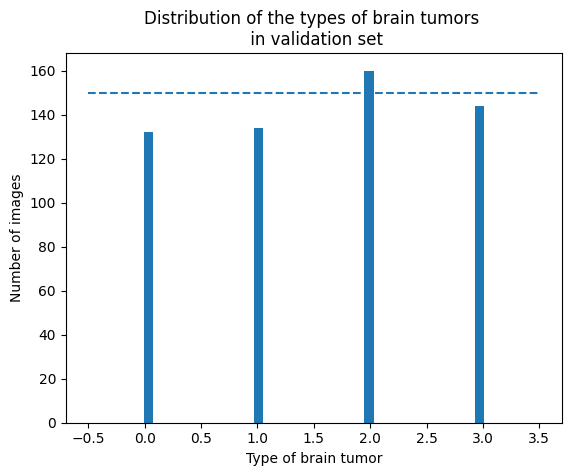

In [14]:
histogram = plt.figure(3)
plt.hlines(150, -0.5, 3.5, linestyles='--')
plt.hist(Y_val, bins=np.linspace(-0.5,3.5))
plt.title('Distribution of the types of brain tumors \n in validation set')
plt.xlabel('Type of brain tumor')
plt.ylabel('Number of images');

In [15]:
# transforming data from uint8 to float32, or normalizing the values of each pixel from 0 to 1

X_train = X_train/255
X_val = X_val/255
x_test = x_test/255

In [16]:
# features scaling

X_train = (X_train - X_train.mean())/(X_train.std())
x_val = (X_val - X_val.mean())/(X_val.std())
x_test = (x_test - x_test.mean())/(x_test.std())

In [17]:
# one hot encoding

from keras.utils.np_utils import to_categorical


y_train_OHE = to_categorical(Y_train)    
y_val_OHE = to_categorical(Y_val)        
y_test_OHE = to_categorical(y_test)

[0. 1. 0. 0.]


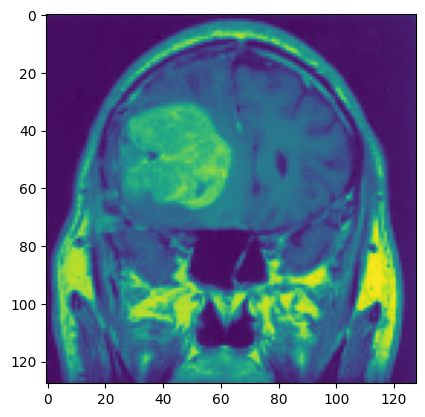

In [60]:
print(y_train_OHE[1])  #  for example
plt.imshow(X_train[1])  # no cmap = 'gray' to let the tumor be visible
#plt.axis('off')

# the axis show that the image has been correctly redimensioned to 128x128 pixels

# Setting up the neural network

In [19]:
from keras import backend

backend.clear_session()

In [20]:
from keras import Sequential
from keras.layers import Flatten
from keras.layers import Dense      
from keras.layers import Activation   
from keras import initializers
from keras.layers import Conv2D    
from keras.layers import MaxPool2D   

In [21]:
CNNmodel = Sequential()

In [22]:
# defining the early stopping algorithm
from keras import callbacks

early_stop = callbacks.EarlyStopping(monitor="val_accuracy", patience=5, verbose=1, 
                                     mode ="max", restore_best_weights = True)

In [23]:
# first convolutional layer
CNNmodel.add(Conv2D(25, (5,5),
                    strides=(1,1),
                    padding='same',
                    activation = 'relu',
                    input_shape = (img_size, img_size, 1),
                    kernel_initializer = initializers.RandomNormal(stddev=0.01),
                    bias_initializer = initializers.Zeros()))

# first max pooling layer
CNNmodel.add(MaxPool2D(pool_size = (2,2)))


# second convolutional layer
CNNmodel.add(Conv2D(50, (5,5),
                    strides=(1,1),
                    padding='same',
                    activation = 'relu'))

# second max pooling layer
CNNmodel.add(MaxPool2D(pool_size = (2,2)))


# third convolutional layer
CNNmodel.add(Conv2D(100, (5,5),
                    strides=(1,1),
                    padding='same',
                    activation = 'relu'))

# third max pooling layer
CNNmodel.add(MaxPool2D(pool_size = (2,2)))

In [24]:
CNNmodel.add(Flatten())

# a FC layer
CNNmodel.add(Dense(12, activation = ('relu')))


# output layer for classification
CNNmodel.add(Dense(4, activation = ('softmax')))

In [25]:
CNNmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 25)      650       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 25)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 50)        31300     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 50)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 100)       125100    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 100)      0

In [26]:
# Stochastic Gradient Descent
from keras import optimizers

CNN_opt = optimizers.SGD(learning_rate=0.001, momentum = 0.9)

CNNmodel.compile(optimizer = CNN_opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])   
# categorical cross entropy is the loss in multiclass classification problems

# Training Data

In [27]:
# defining epochs and batch size

epochs = 20

batch_size = 64 

In [28]:
# model.fit to do training of the data

history = CNNmodel.fit(
    X_train, y_train_OHE,
    batch_size = batch_size,
    validation_data = (x_val, y_val_OHE),
    epochs = epochs,
    verbose = 1,
    callbacks = [early_stop],
    shuffle = True
    )

Epoch 1/20
81/81 [==============================] - 313s 4s/step - loss: 1.2662 - accuracy: 0.3631 - val_loss: 0.9825 - val_accuracy: 0.5877
Epoch 2/20
81/81 [==============================] - 313s 4s/step - loss: 0.8111 - accuracy: 0.7170 - val_loss: 0.6568 - val_accuracy: 0.7702
Epoch 3/20
81/81 [==============================] - 299s 4s/step - loss: 0.5783 - accuracy: 0.7933 - val_loss: 0.5488 - val_accuracy: 0.8018
Epoch 4/20
81/81 [==============================] - 300s 4s/step - loss: 0.4991 - accuracy: 0.8179 - val_loss: 0.6414 - val_accuracy: 0.7561
Epoch 5/20
81/81 [==============================] - 305s 4s/step - loss: 0.4351 - accuracy: 0.8467 - val_loss: 0.4767 - val_accuracy: 0.8000
Epoch 6/20
81/81 [==============================] - 303s 4s/step - loss: 0.4190 - accuracy: 0.8512 - val_loss: 0.4860 - val_accuracy: 0.8298
Epoch 7/20
81/81 [==============================] - 301s 4s/step - loss: 0.3469 - accuracy: 0.8736 - val_loss: 0.3870 - val_accuracy: 0.8649
Epoch 8/20
81

# Predicting data

In [29]:
y_pred = CNNmodel.predict(x_test)

41/41 [==============================] - 22s 529ms/step


# Visualizing results

Le loss e metriche di performance che la rete ha salvato sono: 
 dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


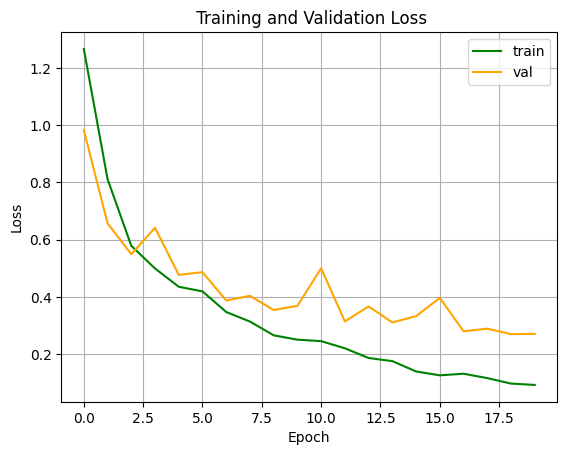

In [63]:
print("Le loss e metriche di performance che la rete ha salvato sono: \n {}".format(history.history.keys()))  

# Plotting Loss

Loss = plt.figure(4)

plt.grid(True)

plt.plot(history.epoch, history.history['loss'], 'g')
plt.plot(history.epoch, history.history['val_loss'], 'orange')

plt.title(' Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')


plt.legend(['train', 'val'], loc='upper right')
plt.show()

Il massimo valore di accuracy raggiunto per il validation set e' pari a: 92.11%
I pesi sono stati comunque salvati all'ultima epoca con validation accuracy pari a 91.23%


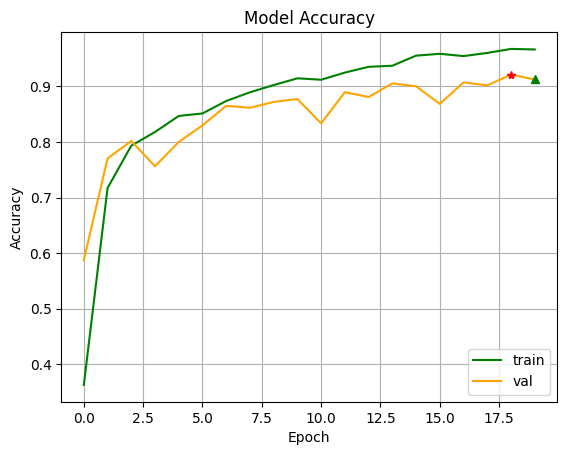

In [47]:
# Plotting Accuracy

Accuracy = plt.figure(5)

plt.grid(True)

plt.plot(history.epoch, history.history['accuracy'], 'g')
plt.plot(history.epoch, history.history['val_accuracy'], 'orange')

max_val_acc = max(history.history['val_accuracy'])
last_val_acc = history.history['val_accuracy'][19]
print("Il massimo valore di accuracy raggiunto per il validation set e' pari a: {:.2%}".format(max_val_acc))
print("I pesi sono stati comunque salvati all'ultima epoca con validation accuracy pari a {:.2%}".format(last_val_acc))

plt.plot(history.epoch[18], max_val_acc, 'r*')
plt.plot(history.epoch[19], last_val_acc, 'g^')


plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [32]:
from sklearn.metrics import confusion_matrix

# confusion matrix for the test set

test_matrix = confusion_matrix(y_test_OHE.argmax(axis=1), y_pred.argmax(axis=1))

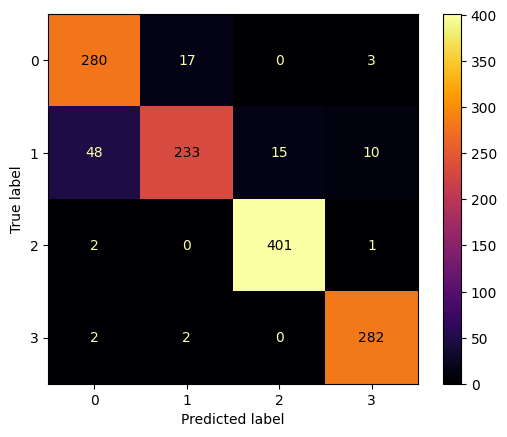

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay

visual_cm = ConfusionMatrixDisplay(confusion_matrix = test_matrix)
visual_cm.plot(cmap='inferno')
plt.show()

In [34]:
# studying the precision

# precision for class 0
p_0 = test_matrix[:,0][0]/(test_matrix[:,0][0]+test_matrix[:,0][1]+test_matrix[:,0][2]+test_matrix[:,0][3])
print("%.2f" %p_0)

# precision for class 1
p_1 = test_matrix[:,1][1]/(test_matrix[:,1][0]+test_matrix[:,1][1]+test_matrix[:,1][2]+test_matrix[:,1][3])
print("%.2f" %p_1)

# precision for class 2
p_2 = test_matrix[:,2][2]/(test_matrix[:,2][0]+test_matrix[:,2][1]+test_matrix[:,2][2]+test_matrix[:,2][3])
print("%.2f" %p_2)

# precision for class 3
p_3 = test_matrix[:,3][3]/(test_matrix[:,3][0]+test_matrix[:,3][1]+test_matrix[:,3][2]+test_matrix[:,3][3])
print("%.2f" %p_3)

0.84
0.92
0.96
0.95


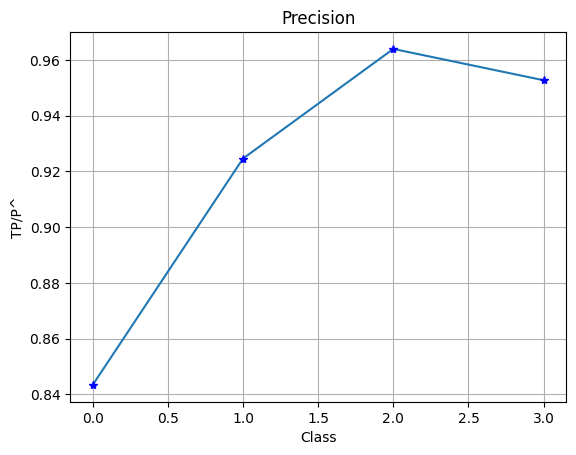

In [35]:
# Plotting Precision

Precision = plt.figure(6)
classes = np.array([0,1,2,3])
precisions = np.array([p_0, p_1, p_2, p_3])

plt.grid(True)

plt.plot(classes, precisions)
plt.plot(0, p_0, 'b*')
plt.plot(1, p_1, 'b*')
plt.plot(2, p_2, 'b*')
plt.plot(3, p_3, 'b*')

plt.title('Precision')
plt.xlabel('Class')
plt.ylabel('TP/P^')

plt.show()

In [36]:
# studying the recall

# recall for class 0
r_0 = (test_matrix[0][0])/(test_matrix[0][0]+test_matrix[0][1]+test_matrix[0][2]+test_matrix[0][3])
print("%.2f" %r_0)

# recall for class 1
r_1 = (test_matrix[1][1])/(test_matrix[1][0]+test_matrix[1][1]+test_matrix[1][2]+test_matrix[1][3])
print("%.2f" %r_1)

# recall for class 2
r_2 = (test_matrix[2][2])/(test_matrix[2][0]+test_matrix[2][1]+test_matrix[2][2]+test_matrix[2][3])
print("%.2f" %r_2)

# recall for class 3
r_3 = (test_matrix[3][3])/(test_matrix[3][0]+test_matrix[3][1]+test_matrix[3][2]+test_matrix[3][3])
print("%.2f" %r_3)

0.93
0.76
0.99
0.99


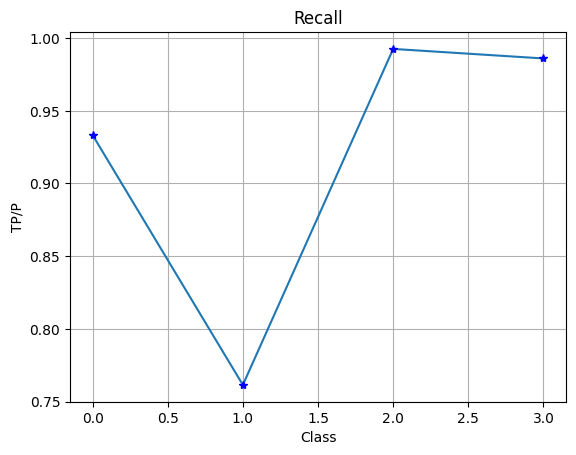

In [37]:
# Plotting Recall

Precision = plt.figure(7)

recalls = np.array([r_0, r_1, r_2, r_3])

plt.grid(True)

plt.plot(classes, recalls)
plt.plot(0, r_0, 'b*')
plt.plot(1, r_1, 'b*')
plt.plot(2, r_2, 'b*')
plt.plot(3, r_3, 'b*')

plt.title('Recall')
plt.xlabel('Class')
plt.ylabel('TP/P')

plt.show()

In [72]:
CNNmodel.save("/content/drive/MyDrive/MRI_Images/Tumors_model.h5")